# Capstone Project:  Face Shape Classification - Part 5

This notebook explores transfer learning from a pre-trained Oxford VGGFace model.

As the VGGFace model was built on older versions of Keras (v2.2.4) and Tensorflow (v1.14.0), hence we will only use the weights from the model and apply to VGG-16 architecture.

More details on VGGFace can be found on [keras-vggface-project](https://github.com/rcmalli/keras-vggface) by [Refik Can Malli](https://www.linkedin.com/in/refik-can-malli-185b5aa4/).  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import pickle
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix

%matplotlib inline


### Define Functions

In [ ]:
def plot_results(mod_history, metric, epochs):

      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()



In [ ]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

### Load Data Files

In [ ]:
path = "/content/drive/MyDrive/CV Project/"

X_train = np.asarray(pickle.load(open(path + "X_train_r224.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_r224.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_r224.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_r224.pickle","rb")))

In [ ]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (510, 224, 224, 1)
y_train shape (510, 5)
--------------------
X_test shape (125, 224, 224, 1)
y_test shape (125, 5)


## <span style = 'color:sienna'>Model TL: Transfer Learning from VGG16 with weights from VGG Face</span>  

In [ ]:
import tensorflow as tf
import torch
import numpy as np
from torchvision.models import vgg16

# 1. First create the Keras model architecture
def build_keras_model():
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3))
    return base_model

keras_model = build_keras_model()

# 2. Load weights only (not full model)
weights_path = '/content/drive/MyDrive/CV Project/save models/rcmalli_vggface_tf_notop_vgg16 (1).h5'
try:
    keras_model.load_weights(weights_path)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")
    exit()

# 3. Create PyTorch model
pt_model = vgg16(pretrained=False)
pt_model.classifier = pt_model.classifier[:-1]  # Remove last layer

# 4. Weight conversion function
def convert_weights(keras_model, pytorch_model):
    pytorch_dict = pytorch_model.state_dict()

    # Keras layer names to PyTorch layer names mapping
    layer_map = {
        'block1_conv1': 'features.0',
        'block1_conv2': 'features.2',
        'block2_conv1': 'features.5',
        'block2_conv2': 'features.7',
        'block3_conv1': 'features.10',
        'block3_conv2': 'features.12',
        'block3_conv3': 'features.14',
        'block4_conv1': 'features.17',
        'block4_conv2': 'features.19',
        'block4_conv3': 'features.21',
        'block5_conv1': 'features.24',
        'block5_conv2': 'features.26',
        'block5_conv3': 'features.28'
    }

    for keras_name, pt_name in layer_map.items():
        # Get Keras layer weights
        keras_layer = keras_model.get_layer(keras_name)
        weights = keras_layer.get_weights()

        # Convert conv2d weights (H,W,inC,outC) -> (outC,inC,H,W)
        w = np.transpose(weights[0], (3, 2, 0, 1))
        pytorch_dict[f'{pt_name}.weight'] = torch.from_numpy(w)

        # Convert biases if exists
        if len(weights) > 1:
            pytorch_dict[f'{pt_name}.bias'] = torch.from_numpy(weights[1])

    return pytorch_dict

# 5. Perform conversion
converted_weights = convert_weights(keras_model, pt_model)
pt_model.load_state_dict(converted_weights)

# 6. Save converted weights
torch.save(pt_model.state_dict(), 'vggface_pytorch_weights.pth')
print("PyTorch weights saved successfully!")

Weights loaded successfully!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PyTorch weights saved successfully!


In [ ]:
torch.save(pt_model.state_dict(), '/content/drive/MyDrive/CV Project/save models/vggface_pytorch_weights.pth')

In [ ]:
import os

# Get file size in bytes
file_path = '/content/vggface_pytorch_weights.pth'
file_size_bytes = os.path.getsize(file_path)

# Convert to human-readable format
def convert_bytes(size):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print(f"Model size: {convert_bytes(file_size_bytes)}")
# Example output: "Model size: 527.34 MB"

Model size: 512.17 MB


VGGFace weights loaded successfully with strict=False!
Epoch 1/50: Train Loss: 1.5495, Acc: 0.2784 | Val Loss: 1.4499, Acc: 0.4160
New best model saved with val_acc: 0.4160
Epoch 2/50: Train Loss: 1.3012, Acc: 0.5059 | Val Loss: 1.2524, Acc: 0.5520
New best model saved with val_acc: 0.5520
Epoch 3/50: Train Loss: 1.0243, Acc: 0.6235 | Val Loss: 1.1392, Acc: 0.5600
New best model saved with val_acc: 0.5600
Epoch 4/50: Train Loss: 0.8375, Acc: 0.6843 | Val Loss: 1.1105, Acc: 0.5840
New best model saved with val_acc: 0.5840
Epoch 5/50: Train Loss: 0.6763, Acc: 0.7529 | Val Loss: 1.2254, Acc: 0.6000
New best model saved with val_acc: 0.6000
Epoch 6/50: Train Loss: 0.5643, Acc: 0.7745 | Val Loss: 1.0630, Acc: 0.6560
New best model saved with val_acc: 0.6560
Epoch 7/50: Train Loss: 0.4547, Acc: 0.8549 | Val Loss: 1.0856, Acc: 0.6400
Epoch 8/50: Train Loss: 0.3731, Acc: 0.8745 | Val Loss: 1.1924, Acc: 0.6240
Epoch 9/50: Train Loss: 0.3615, Acc: 0.8824 | Val Loss: 1.2919, Acc: 0.6480
Epoch 10/

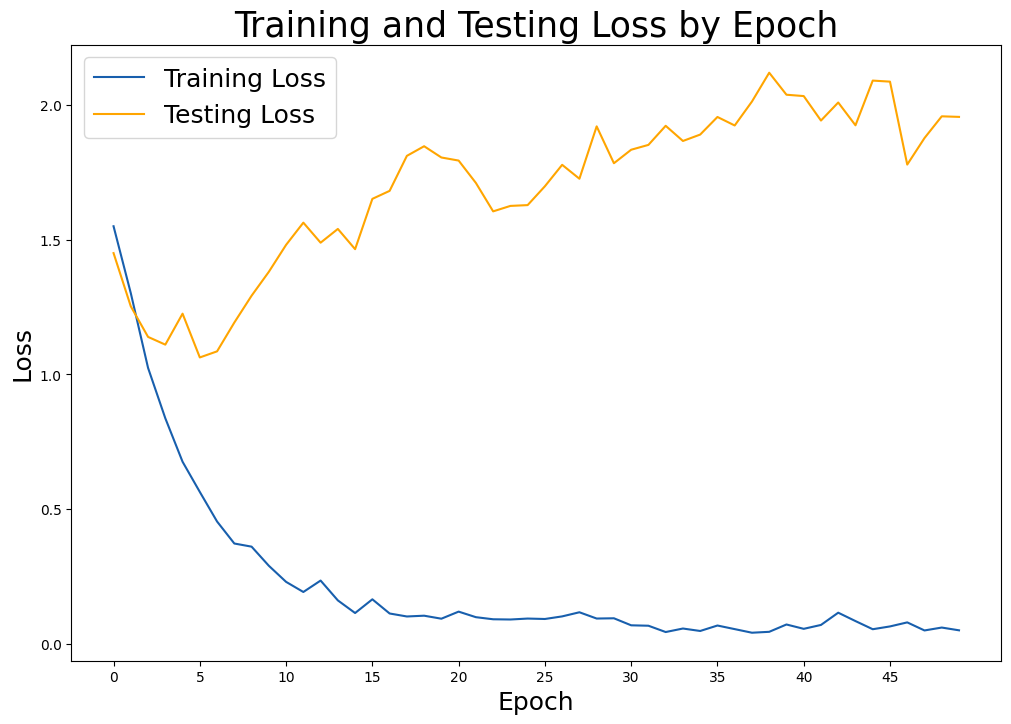

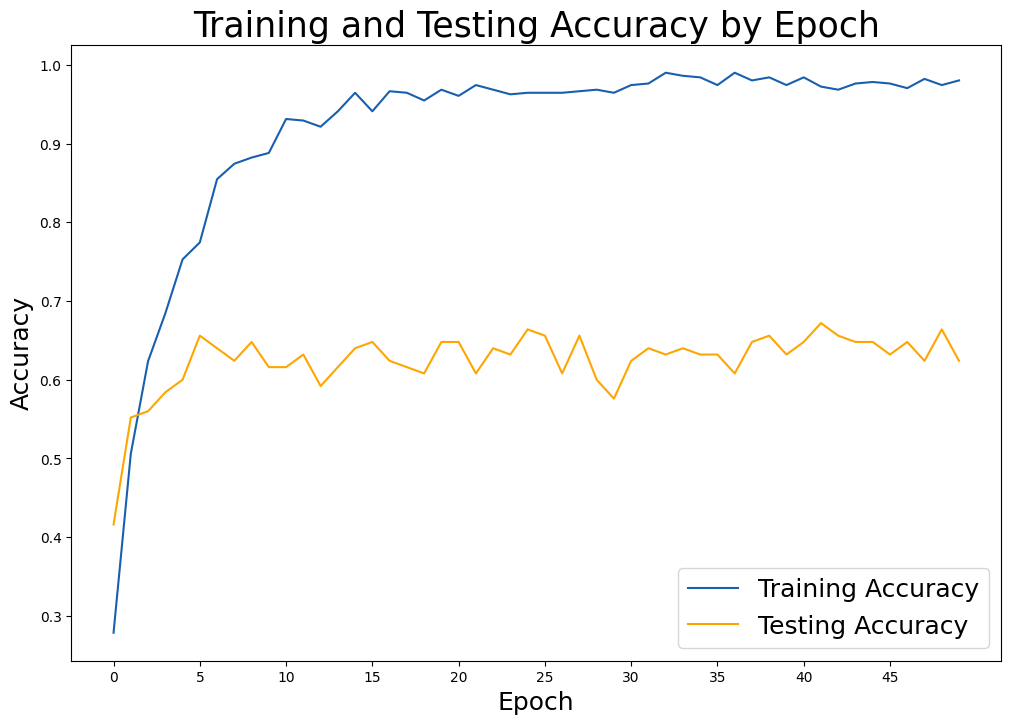

Normalized confusion matrix
[[0.64 0.08 0.12 0.04 0.12]
 [0.12 0.72 0.08 0.08 0.  ]
 [0.4  0.12 0.44 0.   0.04]
 [0.   0.   0.24 0.72 0.04]
 [0.04 0.04 0.16 0.16 0.6 ]]
Training complete and final model saved!


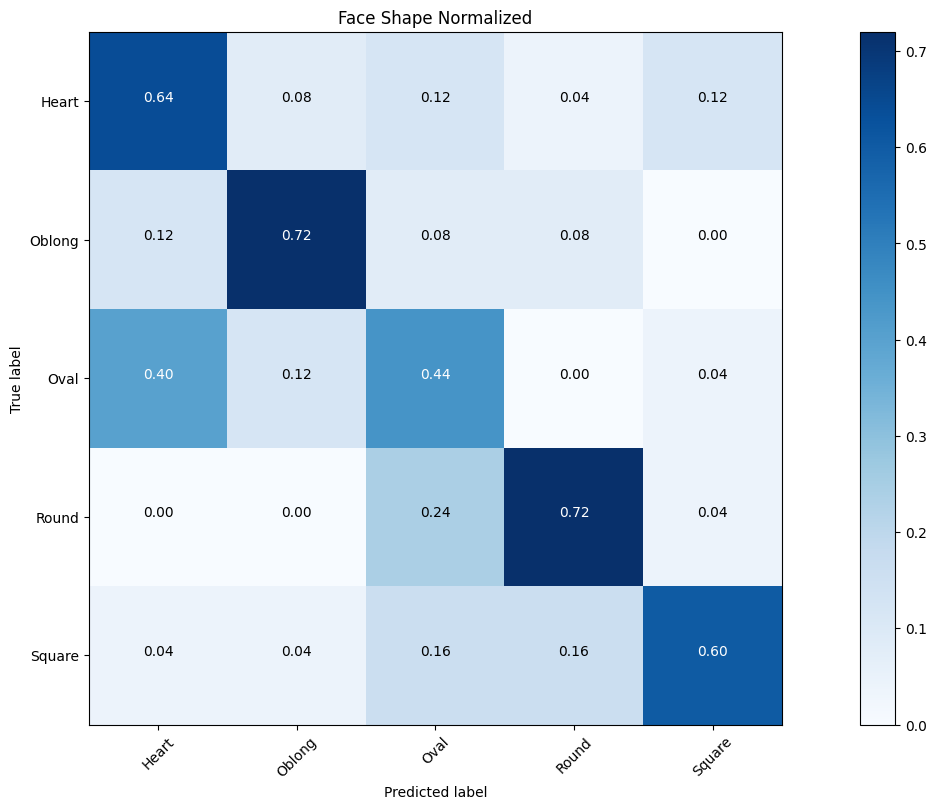

In [ ]:

# Define Functions
def plot_results(train_metric, test_metric, metric_name, epochs):
    plt.figure(figsize=(12, 8))
    plt.plot(train_metric, label=f'Training {metric_name}', color='#185fad')
    plt.plot(test_metric, label=f'Testing {metric_name}', color='orange')
    plt.title(f'Training and Testing {metric_name} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(metric_name, fontsize=18)
    plt.xticks(range(0,epochs,5), range(0,epochs,5))
    plt.legend(fontsize=18)
    plt.show()

cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_summary_results(model, train_losses, val_losses, train_accs, val_accs, epochs, test_loader, device):
    plot_results(train_losses, val_losses, 'Loss', epochs)
    plot_results(train_accs, val_accs, 'Accuracy', epochs)

    # Confusion matrix
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Face Shape Normalized')

# Enhanced Dataset Class with channel handling
class FaceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform or self.get_default_transform()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        # Convert grayscale to RGB if needed
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        if self.transform:
            image = self.transform(image)

        return image, label

    @staticmethod
    def get_default_transform():
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

# Data Augmentation
def get_train_transform():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_test_transform():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load Data
path = "/content/drive/MyDrive/CV Project/"
X_train = np.asarray(pickle.load(open(path + "X_train_r224.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_r224.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_r224.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_r224.pickle","rb")))

# Convert labels if needed
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Create datasets with proper transforms
train_dataset = FaceDataset(X_train, y_train, transform=get_train_transform())
test_dataset = FaceDataset(X_test, y_test, transform=get_test_transform())

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Enhanced Model Definition

class VGGFaceTransfer(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGFaceTransfer, self).__init__()

        # 1. Create base VGG16 model
        self.base_model = models.vgg16(weights=None)  # Updated for torchvision 0.13+

        # 2. Modify the architecture to match VGGFace
        self.features = self.base_model.features
        self.avgpool = self.base_model.avgpool

        # 3. Load VGGFace weights with proper key mapping
        try:
            state_dict = torch.load('/content/drive/MyDrive/CV Project/save models/vggface_pytorch_weights.pth')

            # Create mapping from VGGFace keys to our model's keys
            key_mapping = {}
            for i in [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]:
                key_mapping[f'features.{i}.weight'] = f'{i}.weight'
                key_mapping[f'features.{i}.bias'] = f'{i}.bias'

            # Remap the state dict keys
            new_state_dict = {}
            for k, v in state_dict.items():
                if k in key_mapping:
                    new_state_dict[key_mapping[k]] = v

            # Load the remapped weights
            self.features.load_state_dict(new_state_dict, strict=False)
            print("VGGFace weights loaded successfully with strict=False!")
        except Exception as e:
            print(f"Error loading weights: {e}")
            raise

        # 4. Freeze feature layers
        for param in self.features.parameters():
            param.requires_grad = False

        # 5. Replace classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGGFaceTransfer(num_classes=5).to(device)



# Loss and optimizer (only train classifier)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Enhanced Training Loop with Early Stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=30):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        # Early stopping check
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/CV Project/save models/best_model.pth')
            print(f'New best model saved with val_acc: {best_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

# Plot results
plot_summary_results(model, train_losses, val_losses, train_accs, val_accs, 50, test_loader, device)

# Save final model
torch.save(model.state_dict(), '/content/drive/MyDrive/CV Project/save models/vgg16_face_transfer_final.pth')
print("Training complete and final model saved!")